In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout

In [2]:
bsc_path = 'Datasets'
img_path = os.path.join(bsc_path, 'images')
feature_path = os.path.join(bsc_path, 'gender_classification.csv')

In [3]:
number_images = len(os.listdir(img_path))
print('Total Images', number_images)

Total Images 10000


In [4]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(feature_path)
df.columns = ["image_id", "Gender"]
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Exploratory Data Analysis

## Sample Image

<text>Melihat beberapa image yang ada pada dataset yang akan digunakan untuk membuat model</text>

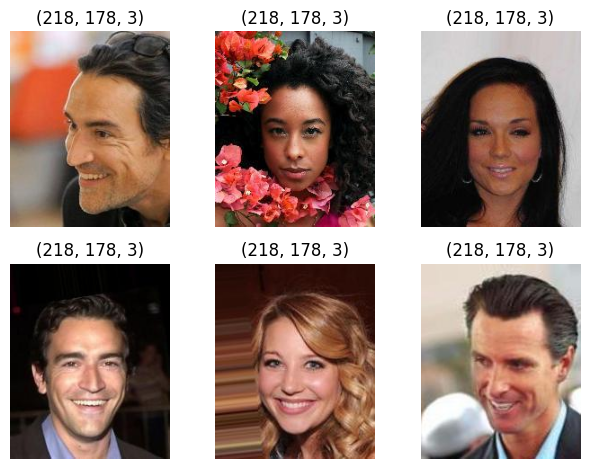

In [5]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(img_path + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Category Distribution

<text>Melihat distribusi dari category gender </text>

In [6]:
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    5861
1    4139
Name: Gender, dtype: int64


<text>0 = Female (Perempuan),
1 = Male (Laki-laki)</text>

## Image Pixel Distribution

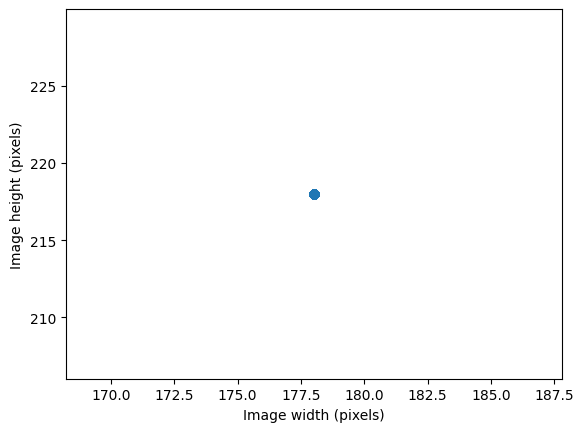

In [7]:
data_dir = 'Datasets/images'
image_sizes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path)
        width, height = img.size
        image_sizes.append((width, height))

# Create scatter plot of image sizes
x = [size[0] for size in image_sizes]
y = [size[1] for size in image_sizes]
plt.scatter(x, y)
plt.xlabel('Image width (pixels)')
plt.ylabel('Image height (pixels)')
plt.show()

<text>Dari sini dapat diambil kesimpulan bahwa semua data images berukuran 218 x 178 pixel</text>

# Data Preprocessing

## Drop Imbalance 

In [8]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

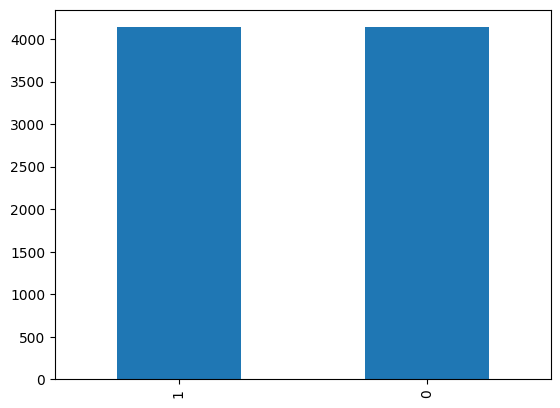

In [9]:
df["Gender"].value_counts().plot.bar()

<text>Berhasil menyeimbangkan data label 0 menyesuaikan dengan label 1 berjumlah 4139 setiap label nya</text>

## Change Value To String

In [10]:
df["Gender"] = df["Gender"].map({0: "0", 1: "1"})

In [11]:
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


## Train Test Split

1. Data akan dibagi menjadi beberapa ukuran training dan test size = 80:20, 70:30, 60:40
2. Diubah ukuran image nya menjadi 224 x 224


In [12]:
train_df_80_20, test_df_80_20 = train_test_split(df, test_size=0.2)
train_df_70_30, test_df_70_30 = train_test_split(df, test_size=0.3)
train_df_60_40, test_df_60_40 = train_test_split(df, test_size=0.4)

In [13]:
print("Total Train Sample Images 80:20 : ", len(train_df_80_20))
print("Total Test Sample Images 80:20 : ", len(test_df_80_20))
print('\n')
print("Total Train Sample Images 70:30 : ", len(train_df_70_30))
print("Total Test Sample Images 70:30 : ", len(test_df_70_30))
print('\n')
print("Total Train Sample Images 60:40 : ", len(train_df_60_40))
print("Total Test Sample Images 60:40 : ", len(test_df_60_40))

Total Train Sample Images 80:20 :  6622
Total Test Sample Images 80:20 :  1656


Total Train Sample Images 70:30 :  5794
Total Test Sample Images 70:30 :  2484


Total Train Sample Images 60:40 :  4966
Total Test Sample Images 60:40 :  3312


## Create Image Data Generator for train and test data

In [14]:
df["image_exists"] = df["image_id"].apply(lambda x: os.path.exists(os.path.join(data_dir, x)))

In [15]:
df = df[df["image_exists"]]
df

,image_id,Gender,image_exists
0,000041.jpg,1,True
1,000044.jpg,0,True
2,000047.jpg,0,True
3,000050.jpg,1,True
4,000063.jpg,0,True
...,...,...,...
9995,202548.jpg,0,True
9996,202554.jpg,1,True
9997,202557.jpg,0,True
9998,202566.jpg,1,True


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
test_gen = ImageDataGenerator(rescale=1./255)

### Train Test 80:20

In [17]:
train_generator_80_20 = train_datagen.flow_from_dataframe(
    train_df_80_20, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_80_20 = test_gen.flow_from_dataframe(
    test_df_80_20, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 6622 validated image filenames belonging to 2 classes.
Found 1656 validated image filenames belonging to 2 classes.


### Train Test 70:30

In [18]:
train_generator_70_30 = train_datagen.flow_from_dataframe(
    train_df_70_30, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_70_30 = test_gen.flow_from_dataframe(
    test_df_70_30, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 5794 validated image filenames belonging to 2 classes.
Found 2484 validated image filenames belonging to 2 classes.


### Train Test 60:40

In [19]:
train_generator_60_40 = train_datagen.flow_from_dataframe(
    train_df_60_40, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_60_40 = test_gen.flow_from_dataframe(
    test_df_60_40, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 4966 validated image filenames belonging to 2 classes.
Found 3312 validated image filenames belonging to 2 classes.


# Modelling

## Modelling 80:20

In [20]:
base_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= (224,224) + (3,))

In [21]:
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
vgg_model_80_20 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)

In [28]:
vgg_model_80_20.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


#### Learning Rate 0.001

In [29]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [32]:
history = vgg_model_80_20.fit(train_generator_80_20, validation_data = test_generator_80_20,
                        epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 60s 287ms/step - loss: 0.3593 - accuracy: 0.8567 - val_loss: 0.2824 - val_accuracy: 0.8937
Epoch 2/5
207/207 [==============================] - 57s 273ms/step - loss: 0.2495 - accuracy: 0.9043 - val_loss: 0.1932 - val_accuracy: 0.9245
Epoch 3/5
207/207 [==============================] - 57s 276ms/step - loss: 0.2408 - accuracy: 0.9071 - val_loss: 0.1684 - val_accuracy: 0.9330
Epoch 4/5
207/207 [==============================] - 58s 280ms/step - loss: 0.2228 - accuracy: 0.9165 - val_loss: 0.1913 - val_accuracy: 0.9318
Epoch 5/5
207/207 [==============================] - 59s 284ms/step - loss: 0.2489 - accuracy: 0.9130 - val_loss: 0.2187 - val_accuracy: 0.9221


Text(0.5, 1.0, 'Loss evolution')

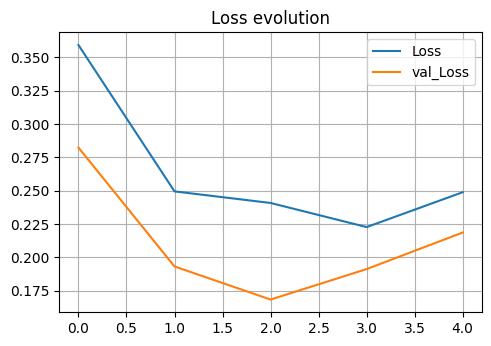

In [33]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

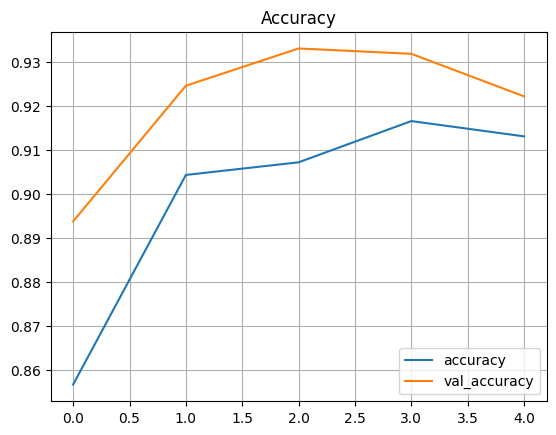

In [34]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [49]:
vgg_model_80_20.save("model_80_20_lr0,0001.h5")

In [36]:
vgg_model_80_20.evaluate(test_generator_80_20)

52/52 [==============================] - 6s 109ms/step - loss: 0.2187 - accuracy: 0.9221


[0.21868948638439178, 0.9221014380455017]

In [37]:
predict = vgg_model_80_20.predict(test_generator_80_20)

52/52 [==============================] - 6s 112ms/step


In [38]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]

In [39]:
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,0
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [40]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[714,  93],
       [ 36, 813]], dtype=int64)

In [41]:
y_pred = vgg_model_80_20.predict(test_generator_80_20)

52/52 [==============================] - 6s 109ms/step


In [42]:
predicted_classes = np.argmax(y_pred, axis=1)

In [43]:
true_classes = test_generator_80_20.classes

In [44]:
class_labels = list(test_generator_80_20.class_indices.keys())

In [45]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       849
           1       0.95      0.88      0.92       807

    accuracy                           0.92      1656
   macro avg       0.92      0.92      0.92      1656
weighted avg       0.92      0.92      0.92      1656



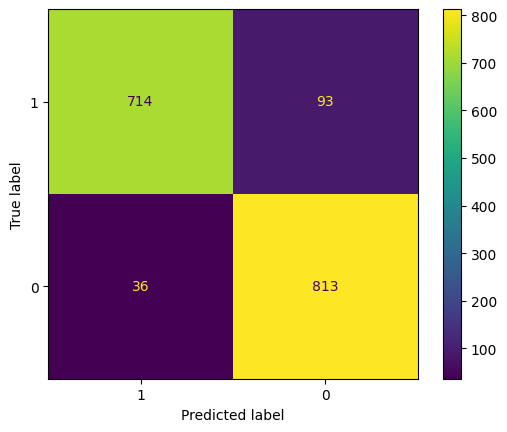

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Learning Rate 0.01

In [82]:
vgg_model_80_20_lr001 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [84]:
learning_rate = 0.01
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20_lr001.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [85]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [86]:
history = vgg_model_80_20_lr001.fit(train_generator_80_20, validation_data = test_generator_80_20,
                                epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 59s 280ms/step - loss: 1.7096 - accuracy: 0.8416 - val_loss: 0.6357 - val_accuracy: 0.9209
Epoch 2/5
207/207 [==============================] - 61s 296ms/step - loss: 1.3390 - accuracy: 0.8745 - val_loss: 1.1250 - val_accuracy: 0.9088
Epoch 3/5
207/207 [==============================] - 60s 291ms/step - loss: 1.1277 - accuracy: 0.8966 - val_loss: 1.0790 - val_accuracy: 0.9118
Epoch 4/5
207/207 [==============================] - 56s 272ms/step - loss: 1.0645 - accuracy: 0.9003 - val_loss: 1.0307 - val_accuracy: 0.9221


Text(0.5, 1.0, 'Loss evolution')

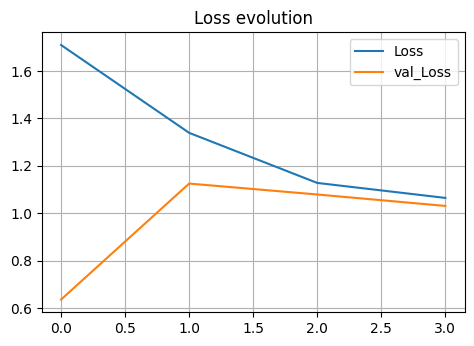

In [87]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

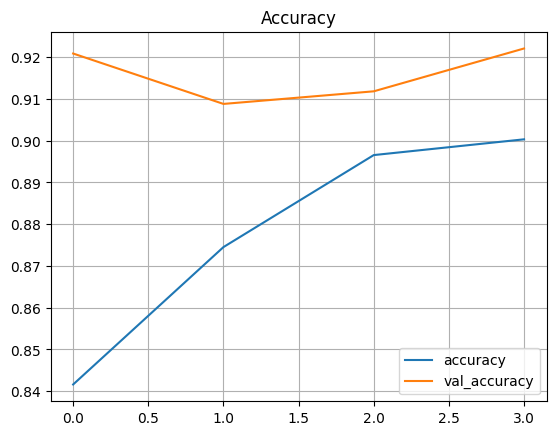

In [88]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [89]:
vgg_model_80_20_lr001.evaluate(test_generator_80_20)

52/52 [==============================] - 6s 108ms/step - loss: 1.0307 - accuracy: 0.9221


[1.030712604522705, 0.9221014380455017]

In [90]:
predict = vgg_model_80_20_lr001.predict(test_generator_80_20)

52/52 [==============================] - 6s 106ms/step


In [91]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [92]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[764,  43],
       [ 86, 763]], dtype=int64)

In [93]:
from sklearn.metrics import classification_report

true_classes = test_generator_80_20.classes

report = classification_report(true_classes, prediction, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       849
           1       0.90      0.95      0.92       807

    accuracy                           0.92      1656
   macro avg       0.92      0.92      0.92      1656
weighted avg       0.92      0.92      0.92      1656



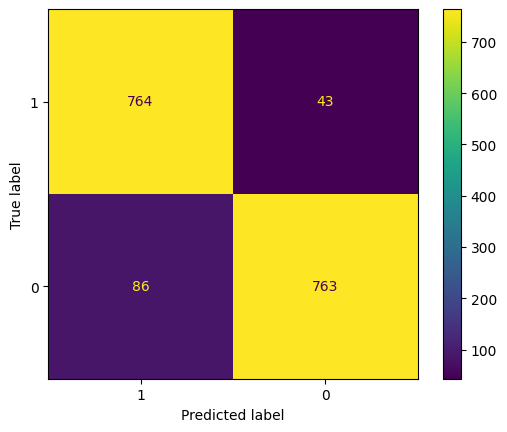

In [94]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Learning Rate 0.1

In [96]:
vgg_model_80_20_lr01 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20_lr01.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [97]:
learning_rate = 0.1
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20_lr01.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [99]:
history = vgg_model_80_20_lr01.fit(train_generator_80_20, validation_data = test_generator_80_20,
                                epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 63s 300ms/step - loss: 25.3138 - accuracy: 0.8223 - val_loss: 9.1344 - val_accuracy: 0.9010
Epoch 2/5
207/207 [==============================] - 58s 280ms/step - loss: 13.9993 - accuracy: 0.8703 - val_loss: 16.6800 - val_accuracy: 0.8973
Epoch 3/5
207/207 [==============================] - 59s 285ms/step - loss: 12.4950 - accuracy: 0.8883 - val_loss: 11.6640 - val_accuracy: 0.9161
Epoch 4/5
207/207 [==============================] - 62s 298ms/step - loss: 10.6228 - accuracy: 0.9076 - val_loss: 9.0901 - val_accuracy: 0.9173
Epoch 5/5
207/207 [==============================] - 60s 287ms/step - loss: 12.4654 - accuracy: 0.8990 - val_loss: 18.6948 - val_accuracy: 0.8859


Text(0.5, 1.0, 'Loss evolution')

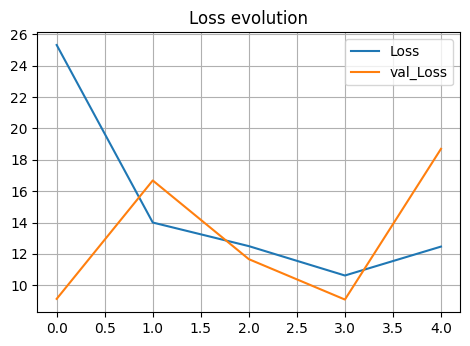

In [100]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

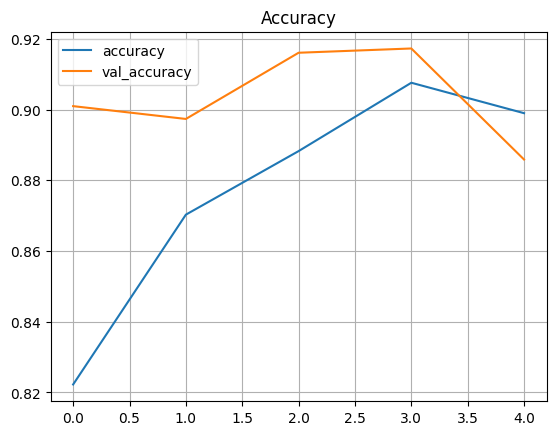

In [101]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [102]:
results = vgg_model_80_20_lr01.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 6s 109ms/step - loss: 18.6948 - accuracy: 0.8859


In [103]:
predict = vgg_model_80_20_lr01.predict(test_generator_80_20)

52/52 [==============================] - 6s 107ms/step


In [104]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,0
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [105]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[632, 175],
       [ 14, 835]], dtype=int64)

In [106]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.83      0.98      0.90       849
           0       0.98      0.78      0.87       807

    accuracy                           0.89      1656
   macro avg       0.90      0.88      0.88      1656
weighted avg       0.90      0.89      0.88      1656



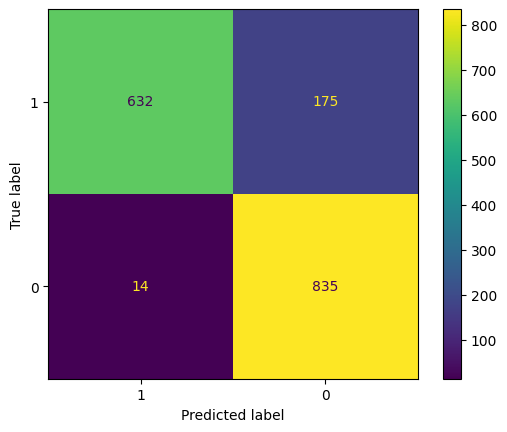

In [107]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Kesimpulan Learning Rate
* Penggunaan learning rate nilai 0.001 lebih optimal karena nilai loss nya lebih kecil dibandingkan dengan penggunaan learning rate 0.01, 0.1

#### Batch_size 16

In [113]:
vgg_model_80_20_bs16 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20_bs16.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [114]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20_bs16.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [115]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [116]:
history = vgg_model_80_20_bs16.fit(train_generator_80_20, validation_data = test_generator_80_20,
                        epochs=5, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 58s 276ms/step - loss: 0.3659 - accuracy: 0.8503 - val_loss: 0.2207 - val_accuracy: 0.9118
Epoch 2/5
207/207 [==============================] - 58s 278ms/step - loss: 0.2849 - accuracy: 0.8908 - val_loss: 0.2045 - val_accuracy: 0.9269
Epoch 3/5
207/207 [==============================] - 59s 282ms/step - loss: 0.2146 - accuracy: 0.9148 - val_loss: 0.1820 - val_accuracy: 0.9312
Epoch 4/5
207/207 [==============================] - 60s 291ms/step - loss: 0.2088 - accuracy: 0.9216 - val_loss: 0.3584 - val_accuracy: 0.8768
Epoch 5/5
207/207 [==============================] - 59s 283ms/step - loss: 0.2178 - accuracy: 0.9188 - val_loss: 0.1735 - val_accuracy: 0.9348


Text(0.5, 1.0, 'Loss evolution')

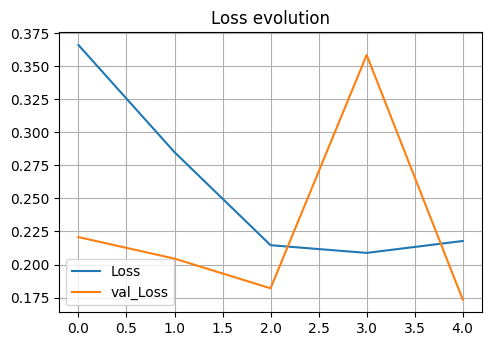

In [117]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

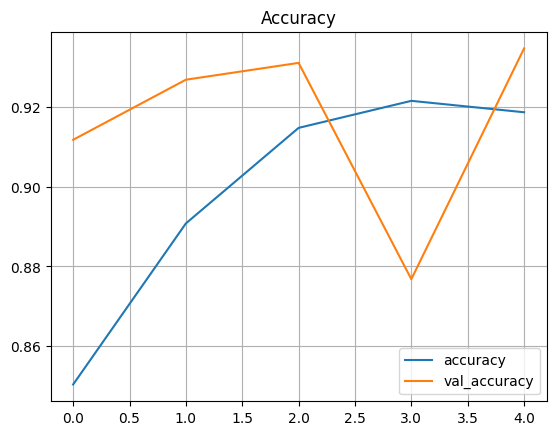

In [118]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [119]:
results = vgg_model_80_20_bs16.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 6s 115ms/step - loss: 0.1735 - accuracy: 0.9348


In [120]:
predict = vgg_model_80_20_bs16.predict(test_generator_80_20)

52/52 [==============================] - 6s 115ms/step


In [121]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [122]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[761,  46],
       [ 62, 787]], dtype=int64)

In [123]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.94      0.93      0.94       849
           0       0.92      0.94      0.93       807

    accuracy                           0.93      1656
   macro avg       0.93      0.93      0.93      1656
weighted avg       0.93      0.93      0.93      1656



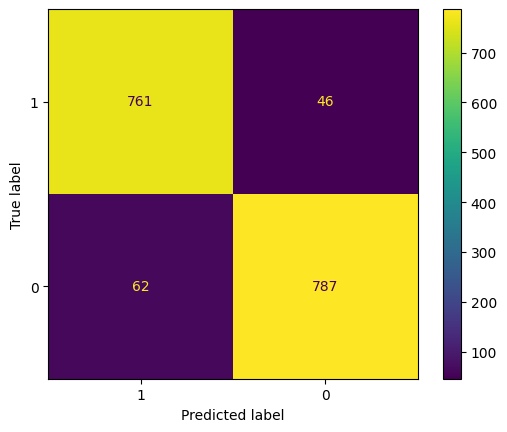

In [124]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Batch Size 32

In [125]:
vgg_model_80_20_bs32 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20_bs32.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [126]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20_bs32.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [127]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [128]:
history = vgg_model_80_20_bs32.fit(train_generator_80_20, validation_data = test_generator_80_20,
                        epochs=5, verbose = 1, batch_size = 32, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 109s 524ms/step - loss: 0.3381 - accuracy: 0.8605 - val_loss: 0.1821 - val_accuracy: 0.9221
Epoch 2/5
207/207 [==============================] - 57s 273ms/step - loss: 0.2319 - accuracy: 0.9094 - val_loss: 0.1673 - val_accuracy: 0.9360
Epoch 3/5
207/207 [==============================] - 56s 272ms/step - loss: 0.2345 - accuracy: 0.9073 - val_loss: 0.1765 - val_accuracy: 0.9342
Epoch 4/5
207/207 [==============================] - 56s 268ms/step - loss: 0.2208 - accuracy: 0.9177 - val_loss: 0.2623 - val_accuracy: 0.9130
Epoch 5/5
207/207 [==============================] - 56s 268ms/step - loss: 0.2069 - accuracy: 0.9236 - val_loss: 0.1923 - val_accuracy: 0.9336


Text(0.5, 1.0, 'Loss evolution')

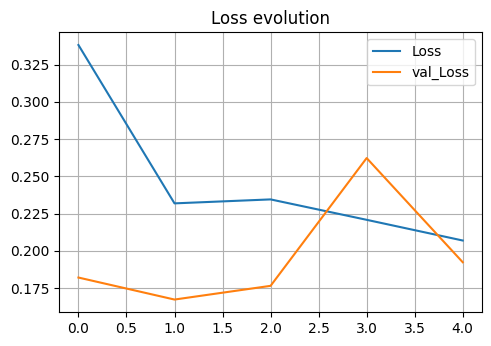

In [129]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

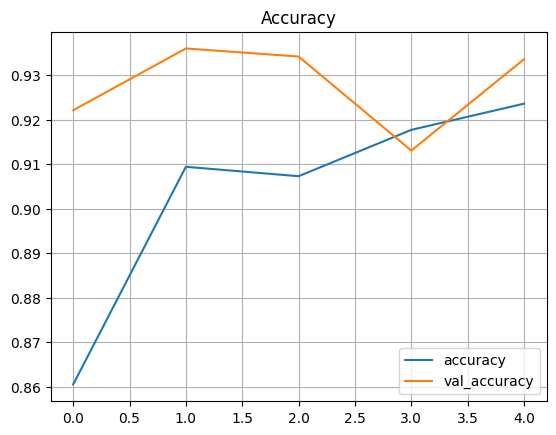

In [130]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [131]:
results = vgg_model_80_20_bs32.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 6s 116ms/step - loss: 0.1923 - accuracy: 0.9336


In [132]:
predict = vgg_model_80_20_bs32.predict(test_generator_80_20)

52/52 [==============================] - 6s 107ms/step


In [133]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [134]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[780,  27],
       [ 83, 766]], dtype=int64)

In [135]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.97      0.90      0.93       849
           0       0.90      0.97      0.93       807

    accuracy                           0.93      1656
   macro avg       0.93      0.93      0.93      1656
weighted avg       0.94      0.93      0.93      1656



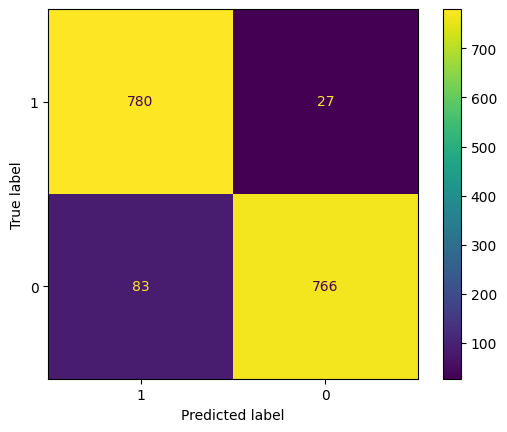

In [136]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Batch Size 64

In [137]:
vgg_model_80_20_bs64 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20_bs64.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [138]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20_bs64.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [139]:
history = vgg_model_80_20_bs64.fit(train_generator_80_20, validation_data = test_generator_80_20,
                                epochs=5, verbose = 1, batch_size = 64, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 58s 277ms/step - loss: 0.3356 - accuracy: 0.8570 - val_loss: 0.1958 - val_accuracy: 0.9191
Epoch 2/5
207/207 [==============================] - 57s 276ms/step - loss: 0.2579 - accuracy: 0.8970 - val_loss: 0.1786 - val_accuracy: 0.9312
Epoch 3/5
207/207 [==============================] - 56s 269ms/step - loss: 0.2329 - accuracy: 0.9091 - val_loss: 0.1963 - val_accuracy: 0.9245
Epoch 4/5
207/207 [==============================] - 60s 290ms/step - loss: 0.2159 - accuracy: 0.9180 - val_loss: 0.2479 - val_accuracy: 0.9173
Epoch 5/5
207/207 [==============================] - 60s 291ms/step - loss: 0.2516 - accuracy: 0.9058 - val_loss: 0.2413 - val_accuracy: 0.9245


Text(0.5, 1.0, 'Loss evolution')

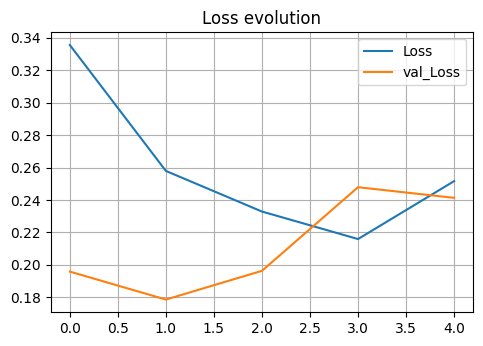

In [140]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

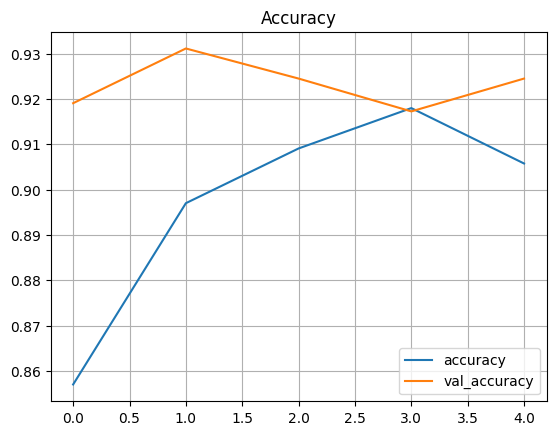

In [141]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [142]:
results = vgg_model_80_20_bs64.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 6s 116ms/step - loss: 0.2413 - accuracy: 0.9245


In [143]:
predict = vgg_model_80_20_bs64.predict(test_generator_80_20)

52/52 [==============================] - 6s 116ms/step


In [144]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [145]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[790,  17],
       [108, 741]], dtype=int64)

In [146]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.98      0.87      0.92       849
           0       0.88      0.98      0.93       807

    accuracy                           0.92      1656
   macro avg       0.93      0.93      0.92      1656
weighted avg       0.93      0.92      0.92      1656



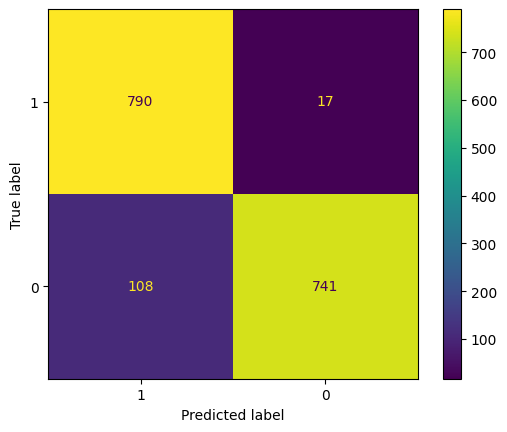

In [147]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

## Modelling 80:20

In [168]:
base_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= (224,224) + (3,))
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [169]:
vgg_model_80_20 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_80_20.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [170]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_80_20.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [171]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_82.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop, checkpoint]

In [172]:
history = vgg_model_80_20.fit(train_generator_80_20, validation_data = test_generator_80_20, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
207/207 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8559
Epoch 1: val_accuracy improved from -inf to 0.92874, saving model to Datasets\gender_classification_model_82.h5
207/207 [==============================] - 60s 287ms/step - loss: 0.3435 - accuracy: 0.8559 - val_loss: 0.1975 - val_accuracy: 0.9287
Epoch 2/20
207/207 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9037
Epoch 2: val_accuracy improved from 0.92874 to 0.92935, saving model to Datasets\gender_classification_model_82.h5
207/207 [==============================] - 59s 285ms/step - loss: 0.2383 - accuracy: 0.9037 - val_loss: 0.2017 - val_accuracy: 0.9293
Epoch 3/20
207/207 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9073
Epoch 3: val_accuracy improved from 0.92935 to 0.93599, saving model to Datasets\gender_classification_model_82.h5
207/207 [==============================] - 59s 287ms/step - loss: 0.2453 - accuracy: 0.9073 - val_loss

Text(0.5, 1.0, 'Loss evolution')

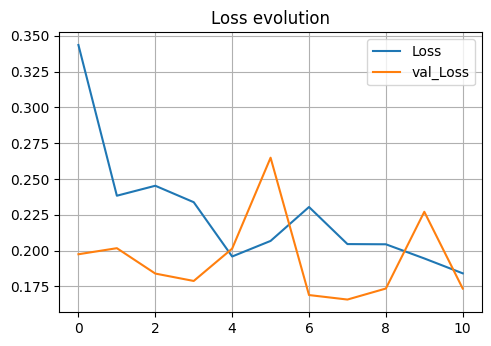

In [173]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

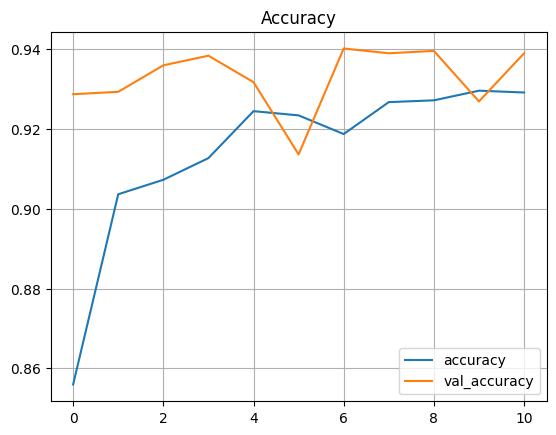

In [174]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [175]:
results = vgg_model_80_20_bs16.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 7s 124ms/step - loss: 0.1735 - accuracy: 0.9348


In [176]:
predict = vgg_model_80_20_bs16.predict(test_generator_80_20)

52/52 [==============================] - 6s 120ms/step


In [177]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [178]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[761,  46],
       [ 62, 787]], dtype=int64)

In [179]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.94      0.93      0.94       849
           0       0.92      0.94      0.93       807

    accuracy                           0.93      1656
   macro avg       0.93      0.93      0.93      1656
weighted avg       0.93      0.93      0.93      1656



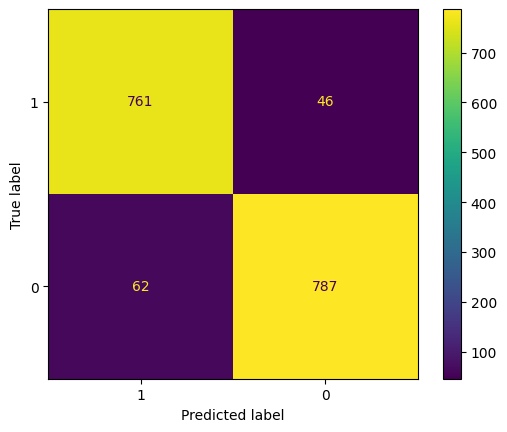

In [180]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

## Modelling 70:30

In [181]:
base_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= (224,224) + (3,))
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [182]:
vgg_model_70_30 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_70_30.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_15 (Flatten)        (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [183]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_70_30.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [184]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_73.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop, checkpoint]

In [185]:
history = vgg_model_70_30.fit(train_generator_70_30, validation_data = test_generator_70_30, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8585
Epoch 1: val_accuracy improved from -inf to 0.91989, saving model to Datasets\gender_classification_model_73.h5
182/182 [==============================] - 58s 313ms/step - loss: 0.3301 - accuracy: 0.8585 - val_loss: 0.2207 - val_accuracy: 0.9199
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9101
Epoch 2: val_accuracy did not improve from 0.91989
182/182 [==============================] - 57s 311ms/step - loss: 0.2363 - accuracy: 0.9101 - val_loss: 0.2410 - val_accuracy: 0.9070
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9108
Epoch 3: val_accuracy did not improve from 0.91989
182/182 [==============================] - 56s 309ms/step - loss: 0.2293 - accuracy: 0.9108 - val_loss: 0.2146 - val_accuracy: 0.9175
Epoch 4/20
182/182 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9208


In [186]:
results = vgg_model_70_30.evaluate(test_generator_70_30)
accuracy = results[1]

78/78 [==============================] - 10s 123ms/step - loss: 0.2236 - accuracy: 0.9312


In [187]:
predict = vgg_model_70_30.predict(test_generator_70_30)

78/78 [==============================] - 9s 121ms/step


In [188]:
prediction = predict.argmax(axis=-1)
test_df_70_30['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_70_30

,image_id,Gender,Prediction
1662,033417.jpg,1,1
8733,177330.jpg,1,1
9295,188623.jpg,0,0
5592,113713.jpg,0,1
1829,036818.jpg,0,0
...,...,...,...
1435,029101.jpg,0,0
7549,153031.jpg,0,0
8944,181185.jpg,0,0
7631,154824.jpg,0,0


In [189]:
labels = ['1','0']

cm = confusion_matrix(test_df_70_30['Gender'], test_df_70_30["Prediction"], labels= labels)
cm

array([[1186,  114],
       [  57, 1127]], dtype=int64)

In [191]:
from sklearn.metrics import classification_report
true_classes = test_generator_70_30.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.91      0.95      0.93      1184
           0       0.95      0.91      0.93      1300

    accuracy                           0.93      2484
   macro avg       0.93      0.93      0.93      2484
weighted avg       0.93      0.93      0.93      2484



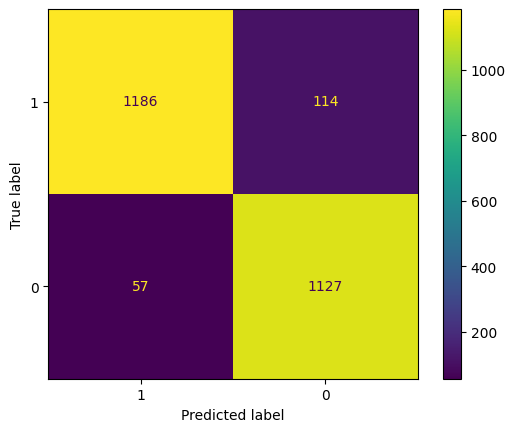

In [192]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

## Modelling 60:40

In [193]:
base_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= (224,224) + (3,))
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [194]:
vgg_model_60_40 = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(2, activation='sigmoid')
]
)
vgg_model_60_40.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_16 (Flatten)        (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [195]:
learning_rate = 0.001
optimizer=Adam(learning_rate=learning_rate)
vgg_model_60_40.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [196]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop, checkpoint]

In [197]:
history = vgg_model_60_40.fit(train_generator_60_40, validation_data = test_generator_60_40, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
156/156 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8365
Epoch 1: val_accuracy improved from -inf to 0.91486, saving model to Datasets\gender_classification_model_64.h5
156/156 [==============================] - 54s 343ms/step - loss: 0.3970 - accuracy: 0.8365 - val_loss: 0.2203 - val_accuracy: 0.9149
Epoch 2/20
156/156 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9104
Epoch 2: val_accuracy improved from 0.91486 to 0.92814, saving model to Datasets\gender_classification_model_64.h5
156/156 [==============================] - 52s 332ms/step - loss: 0.2251 - accuracy: 0.9104 - val_loss: 0.1990 - val_accuracy: 0.9281
Epoch 3/20
156/156 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9150
Epoch 3: val_accuracy improved from 0.92814 to 0.92965, saving model to Datasets\gender_classification_model_64.h5
156/156 [==============================] - 55s 349ms/step - loss: 0.2159 - accuracy: 0.9150 - val_loss

In [198]:
results = vgg_model_60_40.evaluate(test_generator_60_40)
accuracy = results[1]

104/104 [==============================] - 12s 113ms/step - loss: 0.2077 - accuracy: 0.9321


In [199]:
predict = vgg_model_60_40.predict(test_generator_60_40)

104/104 [==============================] - 11s 108ms/step


In [200]:
prediction = predict.argmax(axis=-1)
test_df_60_40['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_60_40

,image_id,Gender,Prediction
6863,139583.jpg,0,0
945,018484.jpg,1,1
4267,086303.jpg,1,1
7964,161904.jpg,1,1
5554,112970.jpg,0,0
...,...,...,...
3982,080995.jpg,1,1
6547,133367.jpg,1,1
9566,194196.jpg,0,0
1059,020870.jpg,0,0


In [201]:
labels = ['1','0']

cm = confusion_matrix(test_df_60_40['Gender'], test_df_60_40["Prediction"], labels= labels)
cm

array([[1548,  131],
       [  94, 1539]], dtype=int64)

In [202]:
from sklearn.metrics import classification_report
true_classes = test_generator_60_40.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.92      0.94      0.93      1633
           0       0.94      0.92      0.93      1679

    accuracy                           0.93      3312
   macro avg       0.93      0.93      0.93      3312
weighted avg       0.93      0.93      0.93      3312



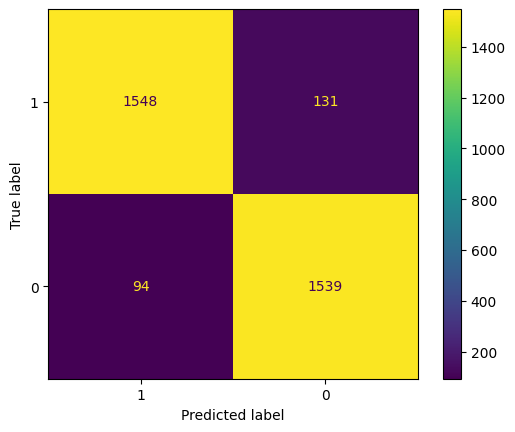

In [203]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()